In [1]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit
import jax.random as random
from functools import partial
from typing import Callable, Union
from collections import namedtuple
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker

from kernel import imq_kernel, rbf_kernel
from model import model
from methods import VGD
from experiment import experiment, diagnostic_experiment
from calculate_mmd import calculate_mmd_squared
from plot_functions import plot_predictives

/home/lqy_unix/Project_3_refactor/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Notes

1. Switch the problem from polynomials $f(x) = \theta_0 + \theta_1 x + \theta_2 x^2 + ... + \theta_p x^p$ (they are unstable when $p$ gets large). Other options (which are fine):
   1. **Trigonemetric Functions** $f(x) = \theta_0 + \theta_1 \sin(x) + \ldots + \theta_p \sin(px)$.
   2. **Polynomial Basis:** E.g. Hermite: $f(x) = \theta_0 H_0(x) + \theta_1 H_1(x) + ... + \theta_p H_p(x)$ where $H_n$ is the $n$-th Hermite polynomial.
2. Thing to try: median heuristic for lengthscale ([this](https://github.com/MatthewAlexanderFisher/vgd/blob/main/src/vgd/methods/vgd.py) is how VGD implements it, [this](https://github.com/MatthewAlexanderFisher/vgd/blob/main/src/vgd/util.py) is the median heuristic code). This hopefully, will speed up convergence.
3. Ensure each misspecified experiment has the same level of **misspecification**. We can do this empirically via having an MMD cutoff between misspecified data and the true model data (or the predictions under the misspecified model).
4. We could consider more "faithful" higher dimensional experiments. E.g. don't have a polynomial basis but consider different covariates: $ y_i = \theta_0 + \theta_{11} x_{i1} + \theta_{12} x_{i2} + \theta_{21} x_{i1}^2 + \varepsilon_i$.

## sin data

In [2]:
def f(theta, x):
  # f(x) = \theta_0 + \theta_1 \sin(x) + \ldots + \theta_p \sin(px)
  theta = jnp.asarray(theta)
  theta_0 = theta[0]
  theta_rest = theta[1:]

  i_vals = jnp.arange(1, theta.shape[0])
  # i_vals[:, None] shape (p, 1)
  # x               shape (n_data,)
  # broadcast product shape (p, n_data)
  products = i_vals[:, None] * x
  
  # vector of sin termes: [sin(1*x), sin(2*x), ..., sin(p*x)]
  sin_terms = jnp.sin(products)
  
  # sum(theta_i * sin(i*x))
  sum_term = jnp.sum(theta_rest[:, None] * sin_terms, axis=0)
  
  return theta_0 + sum_term

f_jit = jit(f)

a = jnp.array([-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1])


sigma = 0.2
sine_model_1 = model(sigma, f_jit, theta_dim=2)
sine_model_2 = model(sigma, f_jit, theta_dim=3)
sine_model_5 = model(sigma, f_jit, theta_dim=6)
sine_model_6 = model(sigma, f_jit, theta_dim=7)
sine_model_10 = model(sigma, f_jit, theta_dim=11)
sine_model_11 = model(sigma, f_jit, theta_dim=12)

theta_1 = a[0:2]
theta_2 = a[0:3]
theta_5 = a[0:6]
theta_6 = a[0:7]
theta_10 = a[0:11]
theta_11 = a[0:12]

n_data = 1000
key = random.PRNGKey(10)
data_1_w = sine_model_1.generate_data(n_data, theta_1, key=key)
data_1_m = sine_model_2.generate_data(n_data, theta_2, key=key)
data_5_w = sine_model_5.generate_data(n_data, theta_5, key=key)
data_5_m = sine_model_6.generate_data(n_data, theta_6, key=key)
data_10_w = sine_model_10.generate_data(n_data, theta_10, key=key)
data_10_m = sine_model_11.generate_data(n_data, theta_11, key=key)

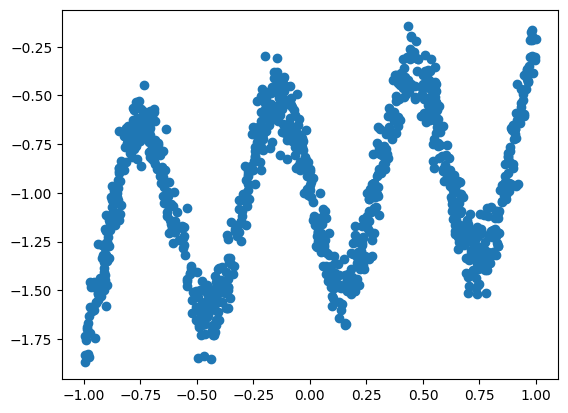

In [41]:
plt.scatter(*data_10_w)

## 1 well

In [10]:
experiment_1_w = experiment(sine_model_1, data_1_w, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
experiment_1_w.run(n_steps=20000, step_size=0.0001)

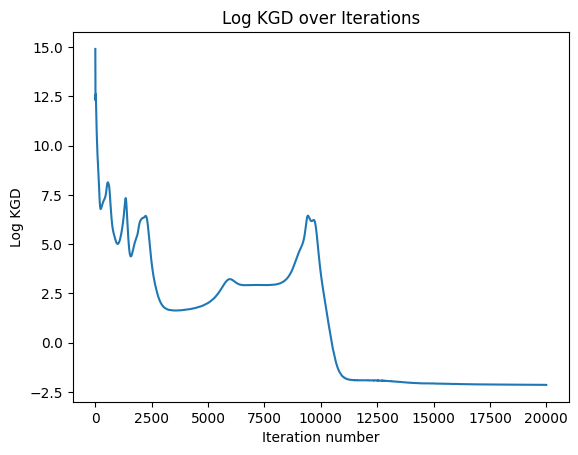

In [11]:
experiment_1_w.plot_KGD()

In [13]:
jnp.mean(experiment_1_w.history_VGD[90000], axis=0)

Array([-0.9922352,  1.0033401], dtype=float32)

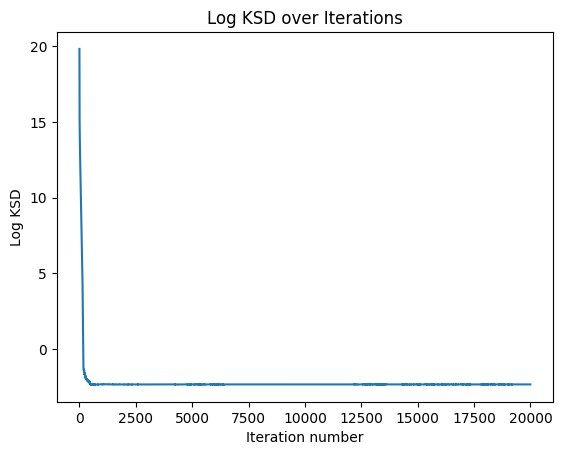

In [12]:
experiment_1_w.plot_KSD()

MMD length scale: 0.5246676
Actual mmd 1.177359e-05


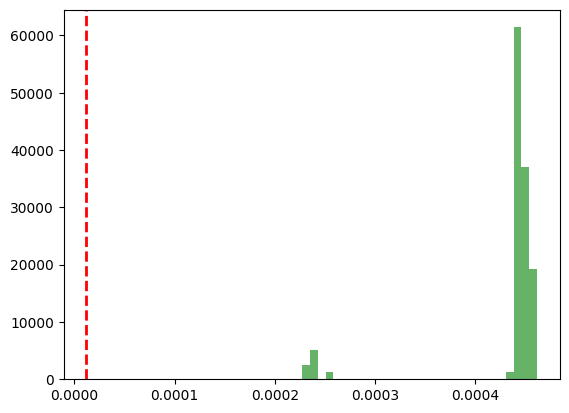

In [14]:
diagnostic_experiment_1_w = diagnostic_experiment(experiment_1_w)
all_mmd_values_1_w, actual_mmd_1_w = diagnostic_experiment_1_w.plot_diagnostic()

## 1 mis

In [15]:
experiment_1_m = experiment(sine_model_1, data_1_m, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(49))
experiment_1_m.run(n_steps=20000, step_size=0.0001)

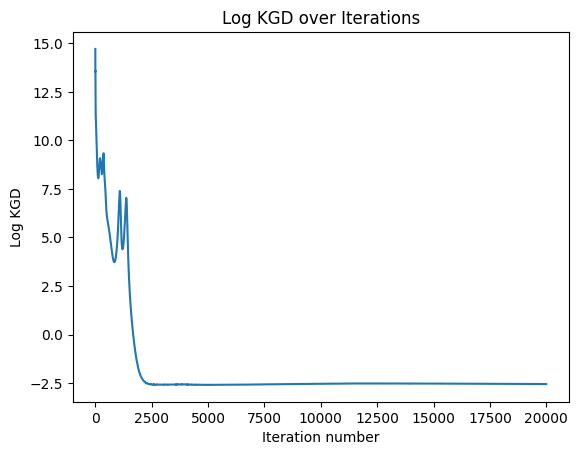

In [16]:
experiment_1_m.plot_KGD()

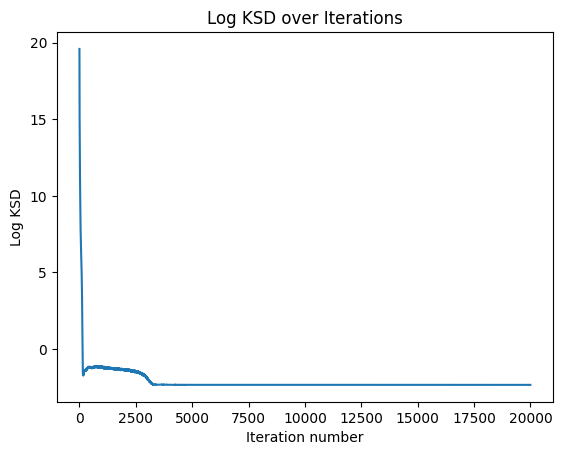

In [17]:
experiment_1_m.plot_KSD()

In [18]:
experiment_1_m.particles_VGD.mean(axis=0)

Array([-0.9678165 , -0.44244614], dtype=float32)

MMD length scale: 0.5357102
Actual mmd 0.0005428499


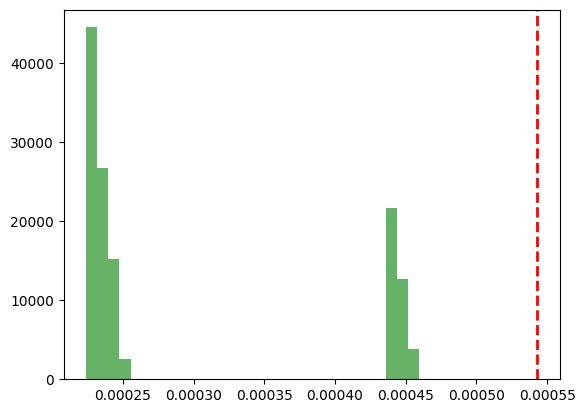

In [19]:
diagnostic_experiment_1_m = diagnostic_experiment(experiment_1_m)
all_mmd_values_1_m, actual_mmd_1_m = diagnostic_experiment_1_m.plot_diagnostic()

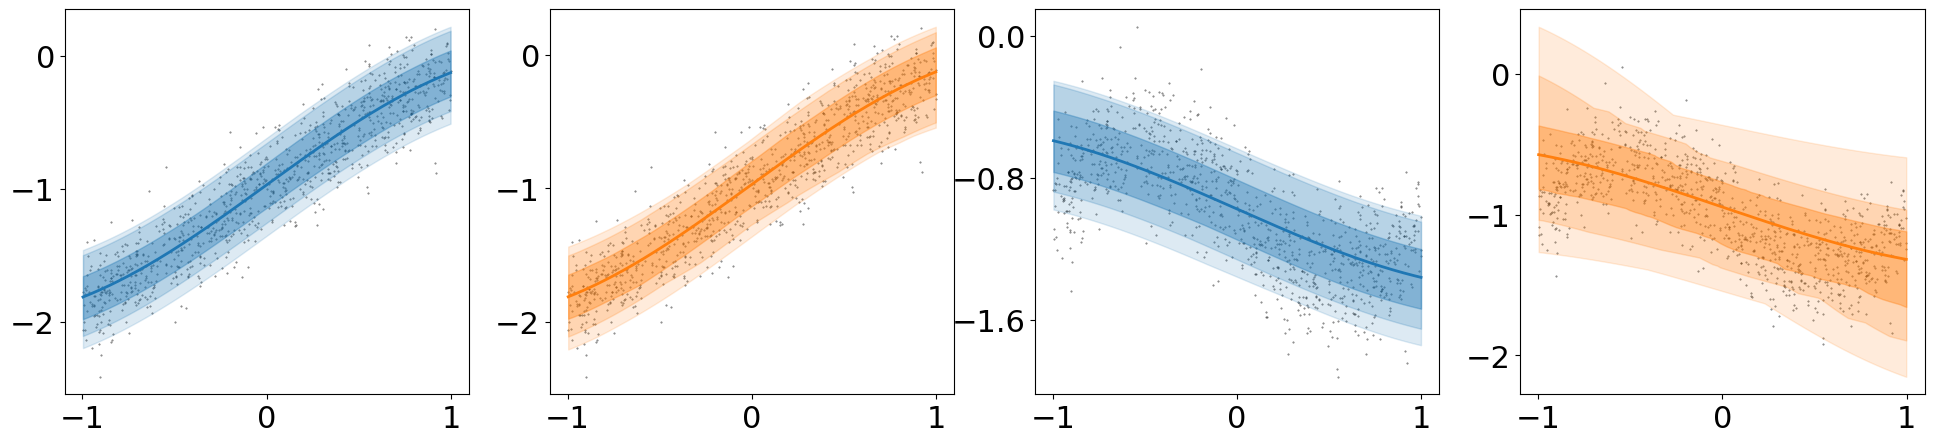

In [20]:
plot_predictives(
    experiment_1_w,
    experiment_1_m, 
    intervals=[50, 80, 90]
)

## 5 well

In [21]:
experiment_5_w = experiment(sine_model_5, data_5_w, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(49))
experiment_5_w.run(n_steps=20000, step_size=0.00005)

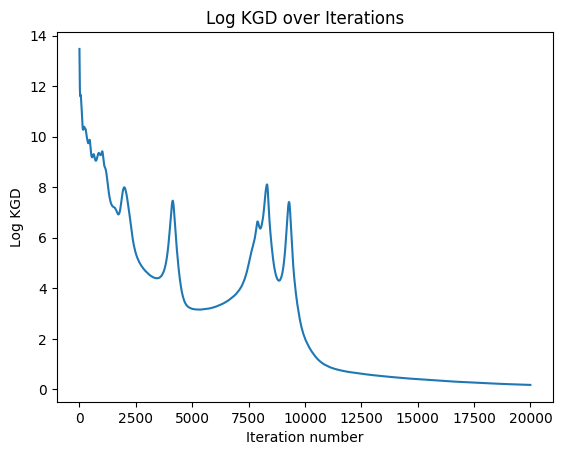

In [22]:
experiment_5_w.plot_KGD()

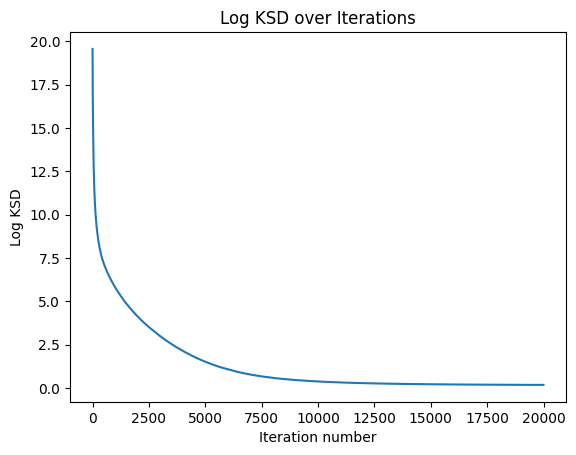

In [23]:
experiment_5_w.plot_KSD()

In [24]:
experiment_5_w.particles_SVGD.mean(axis=0)

Array([-9.9237311e-01,  5.9321809e-01, -5.2078965e-04, -2.4216683e-01,
       -1.8646690e-01,  7.5347966e-01], dtype=float32)

In [25]:
experiment_5_w.particles_VGD.mean(axis=0)

Array([-0.87872106,  0.59121025,  0.01538582, -0.22157852, -0.22709826,
        0.7642395 ], dtype=float32)

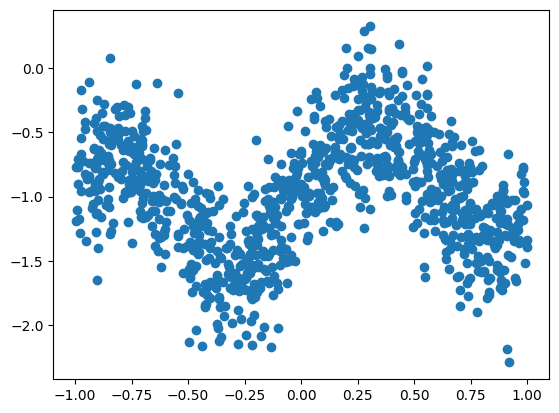

In [35]:
plt.scatter(*data_5_w)

In [26]:
diagnostic_experiment_5_w = diagnostic_experiment(experiment_5_w)
all_mmd_values_5_w, actual_mmd_5_w = diagnostic_experiment_5_w.plot_diagnostic()

W1117 10:31:26.604800    2340 bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 915.53MiB (rounded to 960000000)requested by op 
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
W1117 10:31:26.605191    2340 bfc_allocator.cc:512] *____________***____**************______******************************************************______
E1117 10:31:26.605215    2340 pjrt_stream_executor_client.cc:2974] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 960000000 bytes. [tf-allocator-allocation-error='']


JaxRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 960000000 bytes.

## 5 mis

In [ ]:
experiment_5_m = experiment(sine_model_5, data_5_m, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(49))
experiment_5_m.run(n_steps=20000, step_size=0.00005)

In [ ]:
diagnostic_experiment_5_m = diagnostic_experiment(experiment_5_m)
all_mmd_values_5_m, actual_mmd_5_m = diagnostic_experiment_5_m.plot_diagnostic()

## 10 well

In [31]:
experiment_10_w = experiment(sine_model_10, data_10_w, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(49))
experiment_10_w.run(n_steps=20000, step_size=0.0001)

In [34]:
experiment_10_w.particles_SVGD.mean(axis=0)

Array([-0.9924324 ,  0.22277573, -0.06551003,  0.03597971,  0.11782515,
        0.00564834, -0.20999908,  0.00862385,  0.10988456,  0.294553  ,
       -0.8186855 ], dtype=float32)

In [35]:
experiment_10_w.particles_VGD.mean(axis=0)

Array([-0.99211854,  0.20304279, -0.07065959,  0.0468546 ,  0.13673668,
       -0.00612261, -0.23116942,  0.0198845 ,  0.13391684,  0.26701474,
       -0.8099727 ], dtype=float32)

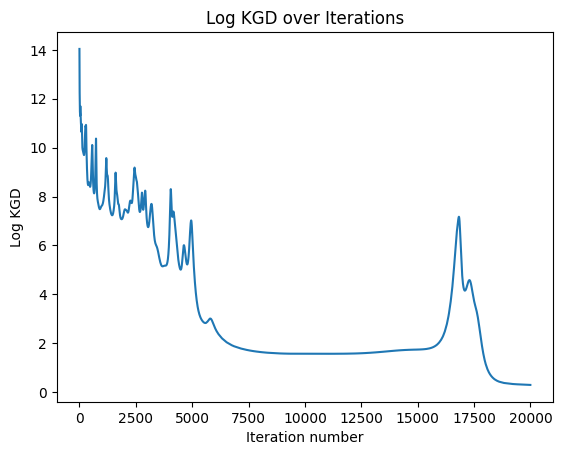

In [33]:
experiment_10_w.plot_KGD()

In [36]:
diagnostic_experiment_10_w = diagnostic_experiment(experiment_10_w)
all_mmd_values_10_w, actual_mmd_10_w = diagnostic_experiment_10_w.plot_diagnostic()

W1117 10:32:50.051861    2340 bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.64GiB (rounded to 1760000000)requested by op 
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
W1117 10:32:50.052195    2340 bfc_allocator.cc:512] *____________*****__**************______******************************************************______
E1117 10:32:50.052222    2340 pjrt_stream_executor_client.cc:2974] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1760000000 bytes. [tf-allocator-allocation-error='']


JaxRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1760000000 bytes.

## 10 mis

In [ ]:
experiment_10_m = experiment(sine_model_10, data_10_m, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(49))
experiment_10_m.run(n_steps=15000, step_size=1e-4, lengthscale=0.1)

100%|██████████| 15000/15000 [00:06<00:00, 2414.57it/s]


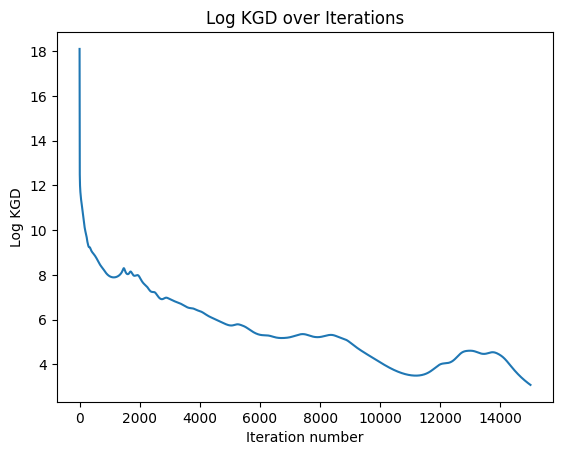

In [16]:
experiment_10_m.plot_KGD()

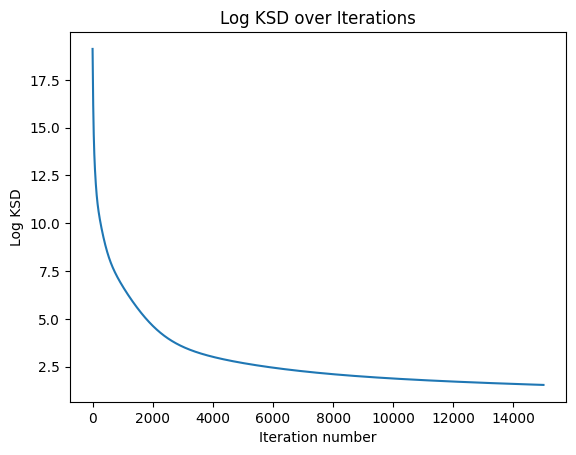

In [17]:
experiment_10_m.plot_KSD()

In [12]:
diagnostic_experiment_10_m = diagnostic_experiment(experiment_10_m)
all_mmd_values_10_m, actual_mmd_10_m = diagnostic_experiment_10_m.plot_diagnostic()

 18%|█▊        | 3669/20000 [01:51<08:16, 32.87it/s]


KeyboardInterrupt: 